<a href="https://colab.research.google.com/github/lorenzosquadrani/convicity/blob/main/try_convicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [1]:
!git clone https://github.com/lorenzosquadrani/convicity.git
!git clone https://github.com/lorenzosquadrani/plasticity.git
!mv /content/plasticity/plasticity/__version__.py.in /content/plasticity/plasticity/__version__.py

Cloning into 'convicity'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 80 (delta 28), reused 56 (delta 14), pack-reused 0
Unpacking objects: 100% (80/80), done.
Cloning into 'plasticity'...
remote: Enumerating objects: 1430, done.
remote: Counting objects: 100% (573/573), done.
remote: Compressing objects: 100% (369/369), done.
remote: Total 1430 (delta 366), reused 376 (delta 202), pack-reused 857
Receiving objects: 100% (1430/1430), 59.47 MiB | 23.29 MiB/s, done.
Resolving deltas: 100% (911/911), done.


In [2]:
cd plasticity/

/content/plasticity


In [3]:
from convicity.cBCM.cBCM import cBCM

from plasticity.model.optimizer import SGD
from plasticity.model.weights import Normal
from convicity.cBCM.utils import view_weights

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt


#Load the Dataset

In [4]:
#load the data
trainset = datasets.MNIST('/content/convicity/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))


testset  =  datasets.MNIST('/content/convicity/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_loader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True)

# Model

In [5]:
class LittleNet(nn.Module):
    def __init__(self):
        super(LittleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=0),
            nn.ReLU()
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8*24*24, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_relu_stack(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

#Training

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

In [ ]:
def train(model, device, trainloader, optimizer, loss_function):
    model.train()
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
    

def test(model, device, testloader, loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

## Training with cBCM for the first convolutional layer

In [63]:
X = np.array(trainset.data, dtype = 'float16')/255.

In [ ]:
model = cBCM(	n_filters = 8, kernel_size = 5,
				num_epochs=5, batch_size = 100, activation = 'relu',
				optimizer = SGD(lr=4e-2), weights_init = Normal(), interaction_strength = -0.,
				random_state = 42, verbose = True)

model.fit(X[:1000])

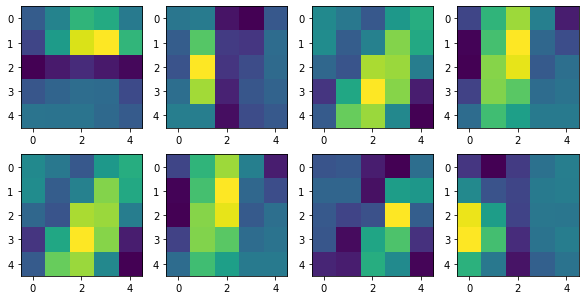

In [65]:
view_weights(model, rows = 2, cols = 4)

In [ ]:
model = LittleNet().to(device)
optimizer = optim.SGD(model.parameters(), lr= lr)
loss_function = nn.CrossEntropyLoss()

In [ ]:
# ASSIGNING VALUES IN THE MODEL

with torch.no_grad():
    model.conv_relu_stack[0].weight.data = torch.tensor(model.weights.reshape(8,1,5,5), device = 'cuda')
    
    torch.zeros((8,1,5,5), device = 'cuda')

##Training without cBCM

In [20]:
lr = 1e-3
num_epochs = 20

In [32]:
model = LittleNet().to(device)
optimizer = optim.SGD(model.parameters(), lr= lr)
loss_function = nn.CrossEntropyLoss()

In [33]:
for epoch in range(num_epochs):
    print("Epoch %d/ %d" %(epoch,num_epochs ))
    train(model, device, train_loader, optimizer, loss_function)
    x, y = test(model, device, test_loader, loss_function)
    print("Test Loss and Accuracy: %f, %d %%" %(x,y))

Epoch 0/ 20
Test Loss and Accuracy: 0.002118, 56 %
Epoch 1/ 20
Test Loss and Accuracy: 0.001911, 70 %
Epoch 2/ 20
Test Loss and Accuracy: 0.001676, 74 %
Epoch 3/ 20
Test Loss and Accuracy: 0.001429, 77 %
Epoch 4/ 20
Test Loss and Accuracy: 0.001199, 79 %
Epoch 5/ 20
Test Loss and Accuracy: 0.001011, 82 %
Epoch 6/ 20
Test Loss and Accuracy: 0.000868, 83 %
Epoch 7/ 20
Test Loss and Accuracy: 0.000763, 84 %
Epoch 8/ 20
Test Loss and Accuracy: 0.000685, 85 %
Epoch 9/ 20
Test Loss and Accuracy: 0.000627, 86 %
Epoch 10/ 20
Test Loss and Accuracy: 0.000582, 86 %
Epoch 11/ 20
Test Loss and Accuracy: 0.000547, 87 %
Epoch 12/ 20
Test Loss and Accuracy: 0.000518, 87 %
Epoch 13/ 20
Test Loss and Accuracy: 0.000495, 87 %
Epoch 14/ 20
Test Loss and Accuracy: 0.000475, 87 %
Epoch 15/ 20
Test Loss and Accuracy: 0.000459, 88 %
Epoch 16/ 20
Test Loss and Accuracy: 0.000445, 88 %
Epoch 17/ 20
Test Loss and Accuracy: 0.000432, 88 %
Epoch 18/ 20
Test Loss and Accuracy: 0.000422, 88 %
Epoch 19/ 20
Test Loss